## 残差网络
ResNet沿用了VGG完整的3*3卷积层设计。 残差块里首先有2个有相同输出通道数的卷积层。 每个卷积层后接一个批量规范化层和ReLU激活函数。 然后我们通过跨层数据通路，跳过这2个卷积运算，将输入直接加在最后的ReLU激活函数前。 这样的设计要求2个卷积层的输出与输入形状一样，从而使它们可以相加。 如果想改变通道数，就需要引入一个额外的卷积层来将输入变换成需要的形状后再做相加运算。 残差块的实现如下：

In [50]:
import torch
from torch import nn
from torch.nn import functional as F
from d2l import torch as d2l


class Residual(nn.Module):  #@save
    def __init__(self, input_channels, num_channels,
                 use_1conv=False, strides=1):
        super().__init__()
        self.preprocess=nn.Sequential()
        self.conv1 = nn.Conv2d(input_channels, num_channels,
                               kernel_size=3, padding=1, stride=strides)
        if use_1conv:
            conv3 = nn.Conv2d(input_channels, num_channels,
                                   kernel_size=1, stride=strides)
            self.preprocess.add_module('1x1conv',conv3)                     
        self.conv2 = nn.Conv2d(num_channels, num_channels,
                               kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(num_channels)
        self.bn2 = nn.BatchNorm2d(num_channels)

    def forward(self, X):
        Y = F.relu(self.bn1(self.conv1(X)))
        Y = self.bn2(self.conv2(Y))
        Y += self.preprocess(X)
        return F.relu(Y)

In [52]:
blk = Residual(3,3)
X = torch.rand(4, 3, 6, 6)
Y = blk(X)
Y.shape

torch.Size([4, 3, 6, 6])

增加输出通道数， 减半输出高和宽

In [53]:
blk=Residual(3, 6, use_1conv=True, strides=2)
blk(X).shape

torch.Size([4, 6, 3, 3])

### ResNet模型

ResNet的前两层跟之前介绍的GoogLeNet中的一样： 在输出通道数为64、步幅为2的卷积层后，接步幅为2的的最大汇聚层。 不同之处在于ResNet每个卷积层后增加了批量规范化层。

In [54]:
b1 = nn.Sequential(nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3),
                   nn.BatchNorm2d(64), nn.ReLU(),
                   nn.MaxPool2d(kernel_size=3, stride=2, padding=1))

GoogLeNet在后面接了4个由Inception块组成的模块。 ResNet则使用4个由残差块组成的模块，每个模块使用若干个同样输出通道数的残差块。 第一个模块的通道数同输入通道数一致。 由于之前已经使用了步幅为2的最大汇聚层，所以无须减小高和宽。 之后的每个模块在第一个残差块里将上一个模块的通道数翻倍，并将高和宽减半。

In [56]:
def resnet_block(in_channels, num_channels, num_residuals, first_block=False):
    blk=[]
    for i in range(num_residuals):
        if i==0 and not first_block:
            blk.append(Residual(in_channels, num_channels, use_1conv=True, strides=2))
        else:
            blk.append(Residual(num_channels, num_channels))
    return blk

接着加入所有残差块

In [57]:
b2 = nn.Sequential(*resnet_block(64, 64, 2, first_block=True))
b3 = nn.Sequential(*resnet_block(64, 128, 2))
b4 = nn.Sequential(*resnet_block(128, 256, 2))
b5 = nn.Sequential(*resnet_block(256, 512, 2))

In [58]:
net = nn.Sequential(b1, b2, b3, b4, b5, nn.AdaptiveAvgPool2d((1, 1)),
                    nn.Flatten(), nn.Linear(512, 10))


观察一下ResNet中不同模块的输入形状是如何变化的。 在之前所有架构中，分辨率降低，通道数量增加，直到全局平均汇聚层聚集所有特征。

In [59]:
X = torch.rand(size=(1, 1, 224, 224))
for layer in net:
    X = layer(X)
    print(layer.__class__.__name__,'output shape:\t', X.shape)

Sequential output shape:	 torch.Size([1, 64, 56, 56])
Sequential output shape:	 torch.Size([1, 64, 56, 56])
Sequential output shape:	 torch.Size([1, 128, 28, 28])
Sequential output shape:	 torch.Size([1, 256, 14, 14])
Sequential output shape:	 torch.Size([1, 512, 7, 7])
AdaptiveAvgPool2d output shape:	 torch.Size([1, 512, 1, 1])
Flatten output shape:	 torch.Size([1, 512])
Linear output shape:	 torch.Size([1, 10])


### 训练模型

loss 0.147, train acc 0.946, test acc 0.924
363.4 examples/sec on cuda:0


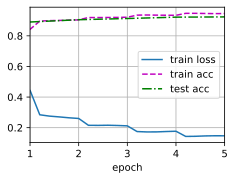

In [49]:
lr, num_epochs, batch_size = 0.05, 5, 5
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size, resize=96)
d2l.train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())